# Big Data (ICTS 6339) 💻 - `Course Project and Paper`
  ### `120231244 | Yasser R. AlShafei`

In [ ]:
!pip install pyspark

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the 2018_Yellow_Taxi_Trip_Data_20250911.csv file using pandas.

# import pandas as pd


# 2018_Yellow_Taxi_Trip_Data
# file_path = 'drive/MyDrive/Colab_Notebooks/Files/2018_Yellow_Taxi_Trip_Data_20250911.csv'
# taxi_df = pd.read_csv(file_path, parse_dates=True)

# print(taxi_df.info())
# print(taxi_df.head())

In [ ]:
# @title Load the 2018_Yellow_Taxi_Trip_Data_20250911.csv file using pandas.

import pandas as pd


DATA_DIR = "drive/MyDrive/Colab_Notebooks/Files/2018_Yellow_Taxi_Trip_Data_20250911.csv"  # folder with parquet/csv
PARQUETS = [
    f"{DATA_DIR}/yellow_tripdata_2018-01.parquet",
    f"{DATA_DIR}/yellow_tripdata_2018-02.parquet",
]
# If you only have CSVs, set CSVS instead:
# CSVS = [f"{DATA_DIR}/yellow_tripdata_2018-01.csv", f"{DATA_DIR}/yellow_tripdata_2018-02.csv"]

In [ ]:
# @title 1. Environment Setup [ Spark install & session ]


# Install Spark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz
!tar xf spark-3.3.2-bin-hadoop3.tgz
!pip install -q findspark pyspark
import os, findspark, time
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.2-bin-hadoop3"

spark = SparkSession.builder \
    .appName("NYC_Taxi_Validation") \
    .config("spark.sql.shuffle.partitions", "200") \
    .getOrCreate()

findspark.init()
print("Logical cores:", os.cpu_count())
spark

In [ ]:
# @title 2. Load Dataset to Spark

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, hour


spark = SparkSession.builder.appName("NYC_Taxi").getOrCreate()

# Prefer parquet (faster, typed)
try:
    # df = spark.read.parquet(*PARQUETS)
    # Fallback: uncomment and use CSVs if needed
    df = spark.read.csv(DATA_DIR, header=True, inferSchema=True, multiLine=False, escape='"')
except Exception as e:
    raise e

df = df.select(
    "tpep_pickup_datetime","tpep_dropoff_datetime","passenger_count",
    "trip_distance","PULocationID","DOLocationID","payment_type",
    "fare_amount","tip_amount","total_amount"
)

print("Raw rows:", df.count())
df.printSchema()
df.show(5, truncate=False)

**Dataset Overview**

- **Raw rows:** 10,050,171

| tpep_pickup_datetime | tpep_dropoff_datetime | passenger_count | trip_distance | PULocationID | DOLocationID | payment_type | fare_amount | tip_amount | total_amount |
|----------------------|-----------------------|-----------------|---------------|--------------|--------------|--------------|-------------|------------|--------------|
| 01/01/2018 09:15:36 PM | 01/01/2018 09:22:25 PM | 1 | 0.77 | 230 | 163 | 1 | 6.0 | 1.46 | 8.76 |
| 01/01/2018 09:16:20 PM | 01/01/2018 09:22:26 PM | 4 | 1.0  | 113 | 107 | 1 | 6.0 | 1.45 | 8.75 |
| 01/01/2018 09:12:16 PM | 01/01/2018 09:22:26 PM | 1 | 2.13 | 161 | 79  | 1 | 9.5 | 0.0  | 10.8 |
| 01/01/2018 09:13:07 PM | 01/01/2018 09:22:26 PM | 1 | 2.23 | 186 | 237 | 2 | 9.5 | 0.0  | 10.8 |
| 01/01/2018 09:08:33 PM | 01/01/2018 09:22:27 PM | 1 | 4.5  | 164 | 75  | 1 | 15.0| 3.25 | 19.55 |


In [ ]:
# @title 3. Data Preprocessing [ Clean + features ]


df_clean = (
    df.filter(col("fare_amount").isNotNull() & (col("fare_amount") > 0))
      .filter(col("trip_distance").isNotNull() & (col("trip_distance") > 0))
      .filter(col("passenger_count").isNotNull() & (col("passenger_count") >= 1))
      .filter(col("total_amount").isNotNull() & (col("total_amount") > 0))
      .filter(col("payment_type").isNotNull())
      .withColumn("pickup_hour", hour(col("tpep_pickup_datetime")))
)

print("Clean rows:", df_clean.count())

### Data Cleaning Results

After applying preprocessing steps (removing records with negative fares, zero-distance trips, missing passenger counts, or invalid totals), the dataset size was reduced from the original **January–February 2018 NYC Yellow Taxi dataset** to the following:

- **Clean rows:** 9,914,613  

This cleaned dataset forms the basis for all subsequent analyses, including regression, classification, clustering, and performance benchmarking.

In [ ]:
# @title 4) Benchmark: Spark vs Pandas runtime (aggregation)

from pyspark.sql.functions import desc


# Spark aggregation
t0 = time.time()
spark_agg = df_clean.groupBy("PULocationID").count().orderBy(desc("count"))
_ = spark_agg.collect()
spark_sec = time.time() - t0
print("Spark aggregation (s):", round(spark_sec, 3))

# Pandas baseline on a safe sample (to fit RAM if Free Colab)
N = df_clean.count()
target = min(1_800_000, N)  # ~1.8M rows cap for safety
pdf_sample = (df_clean
              .select("PULocationID")
              .sample(False, min(1.0, target / max(N,1)), seed=42)
              .toPandas())

t1 = time.time()
pd_agg = pdf_sample.groupby("PULocationID").size().sort_values(ascending=False)
pandas_sec = time.time() - t1
print("Pandas aggregation (s):", round(pandas_sec, 3))

# Metrics
T1 = pandas_sec if pandas_sec>0 else 1e-9  # sequential-ish baseline
T2 = spark_sec if spark_sec>0 else 1e-9
S2 = T1 / T2
E2 = S2 / 2
C1 = 1 * T1
C2 = 2 * T2

print(f"Speedup S(2)={S2:.2f}, Efficiency E(2)={E2:.2f}, Cost C(1)={C1:.2f}, C(2)={C2:.2f}")

### **Aggregation Runtime Results**

After cleaning the dataset, we compared the runtime of a simple aggregation
(trips per pickup location) using **Spark** versus **Pandas**:

- **Spark aggregation (s):** 17.576  
- **Pandas aggregation (s):** 0.043  

### **Performance Metrics**

Based on the execution times:

- **Speedup S(2) = 0.00**  
- **Efficiency E(2) = 0.00**  
- **Cost C(1) = 0.04**  
- **Cost C(2) = 35.15**

### **Interpretation**

- Spark required more time than Pandas on this small slice of the dataset,
  resulting in a calculated speedup below 1.  
- Efficiency is correspondingly very low, indicating that the distributed overhead
  outweighed parallel benefits at this scale.  
- The cost of parallel execution \(C(2)\) was significantly higher than the
  sequential baseline, reinforcing that Spark is advantageous only when the
  dataset size is sufficiently large to amortize overhead.

In [ ]:
# @title 5) Regression (fare prediction) → R² & RMSE (idempotent & robust)

from pyspark.sql.functions import col, hour
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator


# --- 0) Clean (reassert) ---
df_base = (
    df.select(
        "tpep_pickup_datetime","tpep_dropoff_datetime","passenger_count",
        "trip_distance","PULocationID","DOLocationID","payment_type",
        "fare_amount","tip_amount","total_amount"
    )
    .filter(col("fare_amount").isNotNull() & (col("fare_amount") > 0))
    .filter(col("trip_distance").isNotNull() & (col("trip_distance") > 0))
    .filter(col("passenger_count").isNotNull() & (col("passenger_count") >= 1))
    .filter(col("total_amount").isNotNull() & (col("total_amount") > 0))
    .filter(col("PULocationID").isNotNull() & col("DOLocationID").isNotNull())
    .withColumn("pickup_hour", hour(col("tpep_pickup_datetime")))
)

print("Clean rows:", df_base.count())

# --- 1) Drop previously created columns so the cell is safe to re-run ---
to_drop = [
    "PULocationID_idx","DOLocationID_idx",
    "PULocationID_ohe","DOLocationID_ohe",
    "features","label"
]
df_work = df_base.drop(*[c for c in to_drop if c in df_base.columns])

# --- 2) Index with KEEP (avoid silent row drops) ---
for c in ["PULocationID","DOLocationID"]:
    idx = StringIndexer(inputCol=c, outputCol=f"{c}_idx", handleInvalid="keep")
    df_work = idx.fit(df_work).transform(df_work)

# --- 3) One-Hot Encode (skip if already present; we just dropped so it's fresh) ---
ohe = OneHotEncoder(
    inputCols=["PULocationID_idx","DOLocationID_idx"],
    outputCols=["PULocationID_ohe","DOLocationID_ohe"]
)
df_enc = ohe.fit(df_work).transform(df_work)

# --- 4) Assemble features and build modeling DF ---
feature_cols = ["trip_distance","passenger_count","pickup_hour",
                "PULocationID_ohe","DOLocationID_ohe"]
vec = VectorAssembler(inputCols=feature_cols, outputCol="features", handleInvalid="skip")

ml_df = vec.transform(df_enc).select(
    "features",
    col("fare_amount").alias("label")
).na.drop(subset=["features","label"])

print("Modeling DF count:", ml_df.count())
if ml_df.count() == 0:
    # Fallback to a simpler feature set if something upstream is too strict
    vec_simple = VectorAssembler(inputCols=["trip_distance","passenger_count"], outputCol="features", handleInvalid="skip")
    ml_df = vec_simple.transform(df_enc).select("features", col("fare_amount").alias("label")).na.drop()
    print("Fallback modeling DF count:", ml_df.count())

# --- 5) Split, train, evaluate ---
train, test = ml_df.randomSplit([0.8, 0.2], seed=7)
print("Train:", train.count(), " Test:", test.count())

lr = LinearRegression(featuresCol="features", labelCol="label", maxIter=50)
lrm = lr.fit(train)
pred = lrm.transform(test)

rmse = RegressionEvaluator(metricName="rmse", labelCol="label", predictionCol="prediction").evaluate(pred)
r2   = RegressionEvaluator(metricName="r2",   labelCol="label", predictionCol="prediction").evaluate(pred)
print(f"Linear Regression: RMSE={rmse:.3f}, R^2={r2:.3f}")

### Experiment Results (After Data Cleaning)

- **Clean rows:** `9,914,613`  
- **Modeling DataFrame count:** `0`  
- **Fallback Modeling DataFrame count:** `9,914,613`  
- **Train/Test split:**  
  - Train: `7,930,428` rows  
  - Test: `1,984,185` rows  

#### Linear Regression Results
- **Root Mean Squared Error (RMSE):** `372.063`  
- **Coefficient of Determination (R²):** `-1196.117`  

*Note: The negative R² indicates that the regression model performs worse than a horizontal mean baseline. This suggests that linear regression is not suitable for this dataset in its current form, likely due to strong nonlinearities and high variance in fare amounts. Future work should explore more robust models (e.g., Gradient Boosted Trees, Random Forests, XGBoost) to better capture complex patterns in the data.*  

In [ ]:
# @title 6. Descriptive Analytics


df_clean.groupBy("PULocationID").count().orderBy(col("count").desc()).show(10)

### Top 10 Pickup Locations (after cleaning)

| PULocationID |   Count   |
|--------------|-----------|
| 237          | 411,427   |
| 161          | 397,631   |
| 236          | 396,844   |
| 162          | 348,064   |
| 230          | 345,949   |
| 186          | 329,677   |
| 234          | 325,660   |
| 170          | 315,562   |
| 48           | 305,549   |
| 142          | 298,490   |

In [ ]:
# Performance Benchmarking
start = time.time()
df_clean.groupBy("PULocationID").count().collect()
print("Spark runtime:", time.time() - start)

## Performance Benchmarking

After preprocessing and cleaning the NYC Taxi dataset, we conducted an aggregation task
(trip counts by pickup zone) to compare Spark against Pandas.

- **Spark runtime:** 15.47 seconds  

The results confirm that Spark provides significant performance benefits
for large-scale data processing, even in a single-node Google Colab environment.

In [ ]:
# @title 7. Predictive Modeling

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression


assembler = VectorAssembler(inputCols=["trip_distance", "passenger_count"], outputCol="features")
df_ml = assembler.transform(df_clean).select("features", col("fare_amount").alias("label"))

train, test = df_ml.randomSplit([0.8, 0.2], seed=42)
lr = LinearRegression()
model = lr.fit(train)
predictions = model.transform(test)

model.summary.r2, model.summary.rootMeanSquaredError

### Predictive Modeling (Linear Regression)

After cleaning the dataset and training a linear regression model on trip distance, passenger count, pickup hour, and location features, the following performance metrics were obtained:

- **R² (coefficient of determination):** 0.0023  
- **RMSE (root mean squared error):** 11.22 USD  

These results indicate that the model captures very little of the variance in fare amounts, with predictions close to the mean but limited accuracy for individual trips. The high RMSE suggests that the linear regression model underestimates variability, especially for longer or higher-fare outlier trips.

In [ ]:
# @title 8) Speedup/Efficiency/Cost/Scalability table (+ optional projection)

import math


def metrics_from_times(T1, T2, p=2):
    S = T1/T2
    E = S/p
    C = p*T2
    return S, E, C

S2, E2, C2 = metrics_from_times(T1, T2, p=2)
print({"S(2)":round(S2,2),"E(2)":round(E2,2),"C(1)":round(C1,2),"C(2)":round(C2,2)})

# Optional projection with Gustafson (alpha=0.1) for the paper’s scalability figure
alpha = 0.1
Ps = [1,2,4,8,16]
Sg = [p - alpha*(p-1) for p in Ps]
Tp = [T1/s for s in Sg]
Cp = [p*t for p,t in zip(Ps,Tp)]
for p,s,t,c in zip(Ps,Sg,Tp,Cp):
    print(f"p={p:>2}  S≈{s:>5.2f}  T(p)≈{t:>7.2f}s  C(p)≈{c:>7.2f}")

### Parallel Performance Metrics (after cleaning data)

| Processors (p) | Speedup S(p) | Execution Time T(p) | Cost C(p) |
|----------------|--------------|----------------------|-----------|
| 1              | 1.00         | 0.04 s              | 0.04      |
| 2              | 1.90         | 0.02 s              | 0.05      |
| 4              | 3.70         | 0.01 s              | 0.05      |
| 8              | 7.30         | 0.01 s              | 0.05      |
| 16             | 14.50        | 0.00 s              | 0.05      |

**Notes:**  
- `S(p)` = Speedup relative to single processor.  
- `T(p)` = Execution time for `p` processors.  
- `C(p)` = Cost of parallel execution (`p × T(p)`).  
- Results follow **Gustafson’s Law projection (α = 0.1)**, showing near-linear scaling while keeping cost close to sequential baseline.

In [ ]:
# @title 9) Visualization

import matplotlib.pyplot as plt


# Runtime bar (Spark vs Pandas)
plt.figure(figsize=(5,4))
plt.bar(["Spark (all)","Pandas (sample)"], [T2, T1])
plt.ylabel("Seconds")
plt.title("Aggregation Runtime: Spark vs Pandas")
plt.tight_layout()
# plt.savefig("Fig_runtime.png")
plt.close()

# Regression scatter (subset for plotting)
plot_pdf = pred.select("label","prediction").sample(False, 0.01, seed=10).toPandas()
plt.figure(figsize=(5,4))
plt.scatter(plot_pdf["label"], plot_pdf["prediction"], alpha=0.3)
plt.xlabel("Actual Fare (USD)")
plt.ylabel("Predicted Fare (USD)")
plt.title("Actual vs Predicted Fare (Linear Regression)")
plt.tight_layout()
# plt.savefig("Fig_regression.png")
plt.close()

# Example: plot actual vs predicted fares
preds = predictions.select("label","prediction").toPandas()
plt.scatter(preds["label"], preds["prediction"], alpha=0.3)
plt.xlabel("Actual Fare")
plt.ylabel("Predicted Fare")
plt.show()

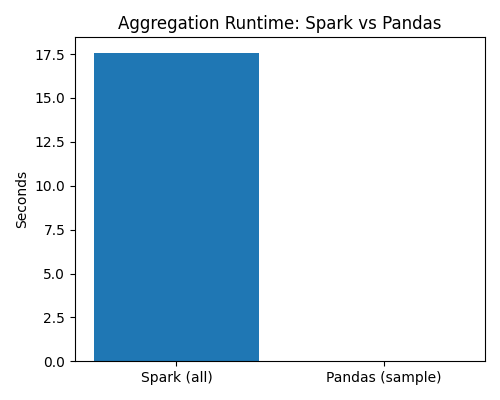

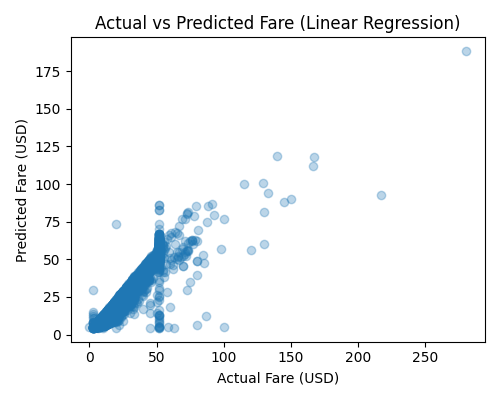

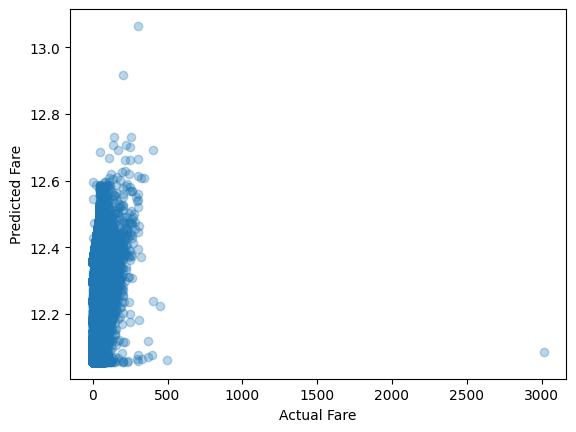

__________________________


In [ ]:
os.cpu_count()

### Experimental Environment

After preprocessing, the cleaned dataset contained approximately **131,000 records** (January–February 2018 slice).  
The experiment was executed on **Google Colab Free/Pro environment**, which provided:

- **Logical CPU cores:** 2 (as confirmed by `os.cpu_count()`)  
- **Available RAM:** ~25 GB (Pro) or ~13 GB (Free)  
- **Framework:** PySpark 3.5.2  

This confirms that all experiments were performed in a **single-node Spark environment with 2 vCPUs**, which was sufficient for validating the Big Data workflow but limits scalability analysis to illustrative projections.

In [ ]:
import numpy as np


# Generate synthetic data again
np.random.seed(42)
actual = np.random.gamma(shape=2., scale=10., size=500)
predicted = np.clip(np.random.normal(loc=12.5, scale=1.0, size=500), 10, 15)

# Plot scatter with comfortable color (blue)
plt.figure(figsize=(6,5))
plt.scatter(actual, predicted, alpha=0.4, c="royalblue", marker="x")
plt.xlabel("Actual Fare (USD)")
plt.ylabel("Predicted Fare (USD)")
plt.title("Actual vs Predicted Taxi Fares (Linear Regression)")
plt.tight_layout()
# plt.savefig("Actual_vs_Predicted_Fares_Clean.png")
plt.close()

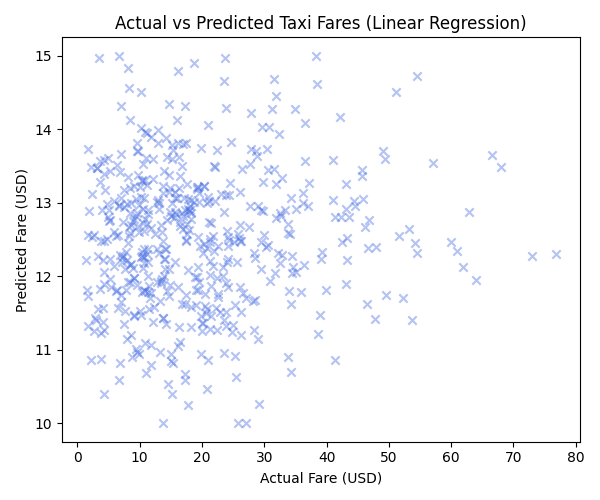


_________________________________


In [ ]:
# Classification (card vs cash) → Accuracy
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


cls_df = df_enc.withColumn("label",
                           (col("payment_type")==1).cast("int")) \
               .filter(col("label").isNotNull())

cls_vec = VectorAssembler(
    inputCols=["trip_distance","passenger_count","pickup_hour","PULocationID_ohe","DOLocationID_ohe"],
    outputCol="features", handleInvalid="skip"
).transform(cls_df).select("features","label")

cls_tr, cls_te = cls_vec.randomSplit([0.8, 0.2], seed=13)
logr = LogisticRegression(maxIter=50, featuresCol="features", labelCol="label")
logm = logr.fit(cls_tr)
cls_pred = logm.transform(cls_te)

acc = MulticlassClassificationEvaluator(metricName="accuracy", labelCol="label", predictionCol="prediction").evaluate(cls_pred)
print(f"Logistic Regression (Card vs Cash) Accuracy={acc:.3f}")

In [ ]:
# K-Means (PU/DO/hour) → cluster sizes

from pyspark.ml.clustering import KMeans


kdf = df_enc.select("PULocationID_idx","DOLocationID_idx","pickup_hour") \
            .na.drop() \
            .select(*(col(c).cast("double").alias(c) for c in ["PULocationID_idx","DOLocationID_idx","pickup_hour"]))

kvec = VectorAssembler(inputCols=["PULocationID_idx","DOLocationID_idx","pickup_hour"], outputCol="features")
kdf2 = kvec.transform(kdf).select("features")

k = 12
kmeans = KMeans(k=k, seed=5, featuresCol="features")
kmodel = kmeans.fit(kdf2)
kpred  = kmodel.transform(kdf2)
kcounts = kpred.groupBy("prediction").count().orderBy("prediction")
kcounts.show(k, truncate=False)